# Dropout
We know about the classical approach
of regularizing statistical models
by penalizing the $L_2$ norm of the weights.
In probabilistic terms, we could justify this technique
by arguing that we have assumed a prior belief
that weights take values from
a Gaussian distribution with mean zero.
More intuitively, we might argue
that we encouraged the model to spread out its weights
among many features rather than depending too much
on a small number of potentially spurious associations.

## Overfitting Revisited

Faced with more features than examples,
linear models tend to overfit.
But given more examples than features,
we can generally count on linear models not to overfit.
Unfortunately, the reliability with which
linear models generalize comes at a cost.
Naively applied, linear models do not take
into account interactions among features.
For every feature, a linear model must assign
either a positive or a negative weight, ignoring context.

In traditional texts, this fundamental tension
between generalizability and flexibility
is described as the *bias-variance tradeoff*.
Linear models have high bias: they can only represent a small class of functions.
However, these models have low variance: they give similar results
across different random samples of the data.

Deep neural networks inhabit the opposite
end of the bias-variance spectrum.
Unlike linear models, neural networks
are not confined to looking at each feature individually.
They can learn interactions among groups of features.
For example, they might infer that
“Nigeria” and “Western Union” appearing
together in an email indicates spam
but that separately they do not.

Even when we have far more examples than features,
deep neural networks are capable of overfitting.
In 2017, a group of researchers demonstrated
the extreme flexibility of neural networks
by training deep nets on randomly-labeled images.
Despite the absence of any true pattern
linking the inputs to the outputs,
they found that the neural network optimized by stochastic gradient descent
could label every image in the training set perfectly.
Consider what this means.
If the labels are assigned uniformly
at random and there are 10 classes,
then no classifier can do better
than 10% accuracy on holdout data.
The generalization gap here is a whopping 90%.
If our models are so expressive that they
can overfit this badly, then when should
we expect them not to overfit?

The mathematical foundations for
the puzzling generalization properties
of deep networks remain open research questions,
and we encourage the theoretically-oriented
reader to dig deeper into the topic.
For now, we turn to the investigation of
practical tools that tend to
empirically improve the generalization of deep nets.

## Robustness through Perturbations

Let us think briefly about what we
expect from a good predictive model.
We want it to peform well on unseen data.
Classical generalization theory
suggests that to close the gap between
train and test performance,
we should aim for a simple model.
Simplicity can come in the form
of a small number of dimensions.

In 1995, Christopher Bishop formalized
this idea when he proved that training with input noise
is equivalent to Tikhonov regularization :cite:`Bishop.1995`.
This work drew a clear mathematical connection
between the requirement that a function be smooth (and thus simple),
and the requirement that it be resilient
to perturbations in the input.

Then, in 2014, Srivastava et al. :cite:`Srivastava.Hinton.Krizhevsky.ea.2014`
developed a clever idea for how to apply Bishop's idea
to the internal layers of a network, too.
Namely, they proposed to inject noise
into each layer of the network
before calculating the subsequent layer during training.
They realized that when training
a deep network with many layers,
injecting noise enforces smoothness just on the input-output mapping.

Their idea, called *dropout*, involves
injecting noise while computing
each internal layer during forward propagation,
and it has become a standard technique
for training neural networks.
The method is called *dropout* because we literally
*drop out* some neurons during training.
Throughout training, on each iteration,
standard dropout consists of zeroing out
some fraction of the nodes in each layer
before calculating the subsequent layer.

To be clear, we are imposing
our own narrative with the link to Bishop.
The original paper on dropout
offers intuition through a surprising
analogy to sexual reproduction.
The authors argue that neural network overfitting
is characterized by a state in which
each layer relies on a specifc
pattern of activations in the previous layer,
calling this condition *co-adaptation*.
Dropout, they claim, breaks up co-adaptation
just as sexual reproduction is argued to
break up co-adapted genes.

The key challenge then is how to inject this noise.
One idea is to inject the noise in an *unbiased* manner
so that the expected value of each layer---while fixing
the others---equals to the value it would have taken absent noise.

In Bishop's work, he added Gaussian noise
to the inputs to a linear model.
At each training iteration, he added noise
sampled from a distribution with mean zero
$\epsilon \sim \mathcal{N}(0,\sigma^2)$ to the input $\mathbf{x}$,
yielding a perturbed point $\mathbf{x}' = \mathbf{x} + \epsilon$.
In expectation, $E[\mathbf{x}'] = \mathbf{x}$.

In standard dropout regularization,
one debiases each layer by normalizing
by the fraction of nodes that were retained (not dropped out).
In other words,
with *dropout probability* $p$,
each intermediate activation $h$ is replaced by
a random variable $h'$ as follows:

$$
\begin{aligned}
h' =
\begin{cases}
    0 & \text{ with probability } p \\
    \frac{h}{1-p} & \text{ otherwise}
\end{cases}
\end{aligned}
$$

By design, the expectation remains unchanged, i.e., $E[h'] = h$.

## Dropout in Practice

Recall the MLP with a hidden layer and 5 hidden units.
When we apply dropout to a hidden layer,
zeroing out each hidden unit with probability $p$,
the result can be viewed as a network
containing only a subset of the original neurons.
In the following figure, $h_2$ and $h_5$ are removed.
Consequently, the calculation of the outputs
no longer depends on $h_2$ or $h_5$
and their respective gradient also vanishes
when performing backpropagation.
In this way, the calculation of the output layer
cannot be overly dependent on any
one element of $h_1, \ldots, h_5$.

Typically, we disable dropout at test time.
Given a trained model and a new example,
we do not drop out any nodes
and thus do not need to normalize.
However, there are some exceptions:
some researchers use dropout at test time as a heuristic
for estimating the *uncertainty* of neural network predictions:
if the predictions agree across many different dropout masks,
then we might say that the network is more confident.

## Implementation from Scratch

To implement the dropout function for a single layer,
we must draw as many samples
from a Bernoulli (binary) random variable
as our layer has dimensions,
where the random variable takes value $1$ (keep)
with probability $1-p$ and $0$ (drop) with probability $p$.
One easy way to implement this is to first draw samples
from the uniform distribution $U[0, 1]$.
Then we can keep those nodes for which the corresponding
sample is greater than $p$, dropping the rest.

In the following code, we (**implement a `dropout_layer` function
that drops out the elements in the tensor input `X`
with probability `dropout`**),
rescaling the remainder as described above:
dividing the survivors by `1.0-dropout`.


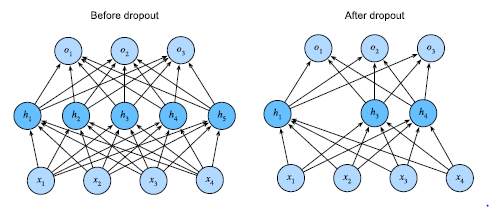

In [1]:
!pip install mxnet
!pip install d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # In this case, all elements are dropped out
    if dropout == 1:
        return np.zeros_like(X)
    # In this case, all elements are kept
    if dropout == 0:
        return X
    mask = np.random.uniform(0, 1, X.shape) > dropout
    return mask.astype(np.float32) * X / (1.0 - dropout)

     |████████████████████████████████| 47.3 MB 1.7 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 82 kB 400 kB/s 
     |████████████████████████████████| 61 kB 4.6 MB/s 
     |████████████████████████████████| 9.9 MB 22.3 MB/s 
     |████████████████████████████████| 20.1 MB 32.3 MB/s 
     |████████████████████████████████| 11.6 MB 50.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Attempting uninstall: m

We can [**test out the `dropout_layer` function on a few examples**].
In the following lines of code,
we pass our input `X` through the dropout operation,
with probabilities 0, 0.5, and 1, respectively.


In [2]:
X = np.arange(16).reshape(2, 8)
print(dropout_layer(X, 0))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1))

[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]]
[[ 0.  2.  4.  6.  8. 10. 12. 14.]
 [ 0. 18. 20.  0.  0.  0. 28.  0.]]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


### Defining Model Parameters

Again, we are working with the Fashion-MNIST dataset.
We [**define an MLP with
two hidden layers containing 256 units each.**]


In [3]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = np.random.normal(scale=0.01, size=(num_inputs, num_hiddens1))
b1 = np.zeros(num_hiddens1)
W2 = np.random.normal(scale=0.01, size=(num_hiddens1, num_hiddens2))
b2 = np.zeros(num_hiddens2)
W3 = np.random.normal(scale=0.01, size=(num_hiddens2, num_outputs))
b3 = np.zeros(num_outputs)

params = [W1, b1, W2, b2, W3, b3]
for param in params:
    param.attach_grad()

### Defining the Model

The model below applies dropout to the output
of each hidden layer (following the activation function).
We can set dropout probabilities for each layer separately.
A common trend is to set
a lower dropout probability closer to the input layer.
Below we set it to 0.2 and 0.5 for the first
and second hidden layers, respectively.
We ensure that dropout is only active during training.


In [4]:
dropout1, dropout2 = 0.2, 0.5

def net(X):
    X = X.reshape(-1, num_inputs)
    H1 = npx.relu(np.dot(X, W1) + b1)
    # Use dropout only when training the model
    if autograd.is_training():
        # Add a dropout layer after the first fully connected layer
        H1 = dropout_layer(H1, dropout1)
    H2 = npx.relu(np.dot(H1, W2) + b2)
    if autograd.is_training():
        # Add a dropout layer after the second fully connected layer
        H2 = dropout_layer(H2, dropout2)
    return np.dot(H2, W3) + b3

### [**Training and Testing**]

This is similar to the training and testing of MLPs described previously.


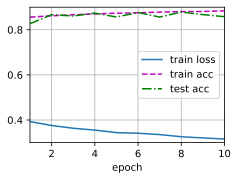

In [7]:
!pip install matplotlib==3.1.3
num_epochs, lr, batch_size = 10, 0.5, 256
loss = gluon.loss.SoftmaxCrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
              lambda batch_size: d2l.sgd(params, lr, batch_size))

## [**Concise Implementation**]

With high-level APIs, all we need to do is add a `Dropout` layer
after each fully-connected layer,
passing in the dropout probability
as the only argument to its constructor.
During training, the `Dropout` layer will randomly
drop out outputs of the previous layer
(or equivalently, the inputs to the subsequent layer)
according to the specified dropout probability.
When not in training mode,
the `Dropout` layer simply passes the data through during testing.


In [8]:
net = nn.Sequential()
net.add(
    nn.Dense(256, activation="relu"),
    # Add a dropout layer after the first fully connected layer
    nn.Dropout(dropout1), nn.Dense(256, activation="relu"),
    # Add a dropout layer after the second fully connected layer
    nn.Dropout(dropout2), nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

Next, we [**train and test the model**].


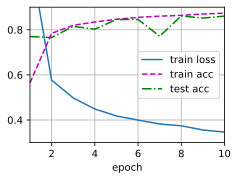

In [9]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## Summary

* Beyond controlling the number of dimensions and the size of the weight vector, dropout is yet another tool to avoid overfitting. Often they are used jointly.
* Dropout replaces an activation $h$ with a random variable with expected value $h$.
* Dropout is only used during training.
